In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import models, datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torchvision.models.resnet import ResNet18_Weights
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理和加载
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class CIFAR10SyntheticDataset(Dataset):
    def __init__(self, npz_file, transform=transform):
        # 加载 npz 文件
        data = np.load(npz_file, allow_pickle=True)
        self.images = data['arr_0']  # CIFAR-10 图片
        self.labels = data['arr_1']  # 对应的标签
        self.transform = transform
         # 手动添加 CIFAR-10 的类别标签
        self.classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx].astype('uint8'))  # 转换为PIL图像
        label = self.labels[idx]  # 取对应的标签
        if self.transform:
            image = self.transform(image)
        return image, label

# 加载数据集
cifar10_syn_path = './synthetic_data/UNet_cifar10-250-sampling_steps-50000_images-class_condn_True.npz'
trainset_syn = CIFAR10SyntheticDataset(cifar10_syn_path, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


# 拆分数据集为训练集和验证集
train_size = int(0.8 * len(trainset_syn))
val_size = len(trainset_syn) - train_size
trainset, valset = torch.utils.data.random_split(trainset_syn, [train_size, val_size])

# 创建 DataLoader
num_workers=4
trainloader = DataLoader(trainset, batch_size=64, shuffle=True,num_workers=num_workers)
valloader = DataLoader(valset, batch_size=64, shuffle=False,num_workers=num_workers)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=num_workers)



# 初始化 TensorBoard
dataset_name = 'CIFAR10_synthetic'
log_dir = f'/root/tf-logs/{dataset_name}'
writer = SummaryWriter(log_dir=log_dir)

# 提前停止参数
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# 创建保存模型的目录
os.makedirs('checkpoints', exist_ok=True)

# 训练函数
def train_model(model, criterion, optimizer, scheduler, trainloader, valloader, device, num_epochs=10):
    global best_val_loss, patience_counter
    model.train()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        batch_iterator = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        for inputs, labels in batch_iterator:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            batch_iterator.set_postfix(loss=loss.item())
        epoch_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Learning_Rate', scheduler.get_last_lr()[0], epoch)
        print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f} Accuracy: {train_accuracy:.2f}%")

        # 验证模型
        val_loss, val_accuracy = evaluate_model(model, criterion, valloader, device, epoch)
        val_losses.append(val_loss)

    return train_losses, val_losses

# 评估函数
def evaluate_model(model, criterion, dataloader, device, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=">>> Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    writer.add_scalar('Loss/val' if dataloader == valloader else 'Loss/test', avg_loss, epoch)
    writer.add_scalar('Accuracy/val' if dataloader == valloader else 'Accuracy/test', accuracy, epoch)
    print(f"    Accuracy: {accuracy:.2f}% Avg_Loss: {avg_loss:.4f}")
    return avg_loss, accuracy



Files already downloaded and verified


In [2]:

# 初始化模型 预训练模型
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# 修改输出层
model.fc = nn.Linear(model.fc.in_features, 10)

model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# 定义 OneCycleLR 学习率调度器
num_epochs = 10
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(trainloader), epochs=num_epochs)

# 训练和评估模型
train_model(model, criterion, optimizer, scheduler, trainloader, valloader, device, num_epochs)

# 关闭 TensorBoard
writer.close()

evaluate_model(model, criterion, testloader, device, num_epochs)

Epoch 1/10: 100%|██████████| 625/625 [00:29<00:00, 20.91batch/s, loss=0.636]


Epoch 1 Loss: 1.3588 Accuracy: 57.53%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 36.08batch/s]


    Accuracy: 80.35% Avg_Loss: 0.6347


Epoch 2/10: 100%|██████████| 625/625 [00:29<00:00, 21.49batch/s, loss=0.416]


Epoch 2 Loss: 0.4285 Accuracy: 85.16%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 37.09batch/s]


    Accuracy: 87.26% Avg_Loss: 0.3653


Epoch 3/10: 100%|██████████| 625/625 [00:29<00:00, 20.99batch/s, loss=0.589] 


Epoch 3 Loss: 0.2979 Accuracy: 89.57%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 36.35batch/s]


    Accuracy: 88.97% Avg_Loss: 0.3113


Epoch 4/10: 100%|██████████| 625/625 [00:28<00:00, 21.83batch/s, loss=0.258] 


Epoch 4 Loss: 0.2256 Accuracy: 92.22%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 36.40batch/s]


    Accuracy: 90.97% Avg_Loss: 0.2648


Epoch 5/10: 100%|██████████| 625/625 [00:29<00:00, 21.03batch/s, loss=0.126] 


Epoch 5 Loss: 0.1717 Accuracy: 93.90%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 36.16batch/s]


    Accuracy: 90.38% Avg_Loss: 0.2819


Epoch 6/10: 100%|██████████| 625/625 [00:29<00:00, 21.53batch/s, loss=0.0583]


Epoch 6 Loss: 0.1268 Accuracy: 95.57%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 36.22batch/s]


    Accuracy: 91.20% Avg_Loss: 0.2728


Epoch 7/10: 100%|██████████| 625/625 [00:28<00:00, 21.89batch/s, loss=0.0396]


Epoch 7 Loss: 0.0855 Accuracy: 97.13%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 36.70batch/s]


    Accuracy: 91.21% Avg_Loss: 0.2865


Epoch 8/10: 100%|██████████| 625/625 [00:28<00:00, 22.00batch/s, loss=0.0456] 


Epoch 8 Loss: 0.0496 Accuracy: 98.48%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 36.59batch/s]


    Accuracy: 91.72% Avg_Loss: 0.2898


Epoch 9/10: 100%|██████████| 625/625 [00:29<00:00, 21.29batch/s, loss=0.0368] 


Epoch 9 Loss: 0.0232 Accuracy: 99.50%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 34.69batch/s]


    Accuracy: 91.98% Avg_Loss: 0.3054


Epoch 10/10: 100%|██████████| 625/625 [00:32<00:00, 19.30batch/s, loss=0.00971]


Epoch 10 Loss: 0.0142 Accuracy: 99.78%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 34.77batch/s]


    Accuracy: 92.12% Avg_Loss: 0.3045


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 35.59batch/s]

    Accuracy: 92.71% Avg_Loss: 0.2891


(0.28912330722543084, 92.71)

Evaluating: 100%|██████████| 157/157 [00:05<00:00, 28.88it/s]


Accuracy: 0.9260
Precision: 0.9258
Recall: 0.9260
F1 Score: 0.9257


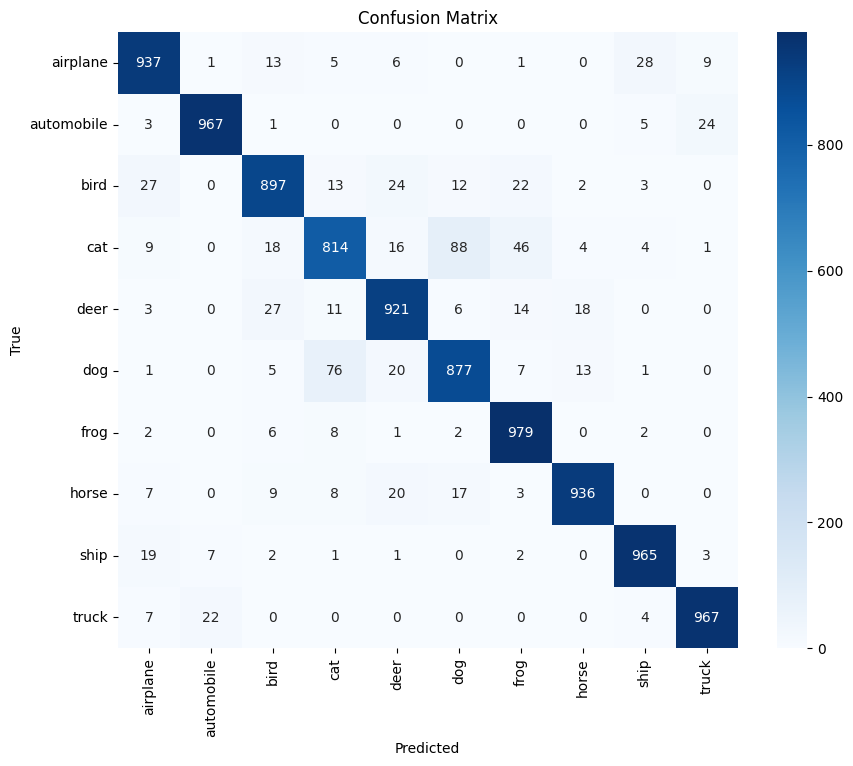

In [22]:
import torch
import torchmetrics
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, F1Score
import matplotlib.pyplot as plt
import seaborn as sns

# 初始化 metrics
accuracy_metric = Accuracy(task='multiclass', num_classes=10).to(device)
precision_metric = Precision(task='multiclass', num_classes=10, average='macro').to(device)
recall_metric = Recall(task='multiclass', num_classes=10, average='macro').to(device)
f1_metric = F1Score(task='multiclass', num_classes=10, average='macro').to(device)
confmat_metric = ConfusionMatrix(task='multiclass', num_classes=10).to(device)

# 评估函数，使用 torchmetrics 计算指标
def evaluate_with_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            
            # 更新 metrics
            accuracy_metric.update(preds, labels)
            precision_metric.update(preds, labels)
            recall_metric.update(preds, labels)
            f1_metric.update(preds, labels)
            confmat_metric.update(preds, labels)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    # 计算最终指标
    accuracy = accuracy_metric.compute().item()
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1 = f1_metric.compute().item()
    confusion_matrix = confmat_metric.compute().cpu().numpy()

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return confusion_matrix

# 可视化混淆矩阵
def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# 在测试集上运行评估
confusion_matrix = evaluate_with_metrics(model, testloader, device)
class_names = testset.classes  # CIFAR-10 类别名称
plot_confusion_matrix(confusion_matrix, class_names)

# 重置所有 metrics 以便在其他数据集上使用
accuracy_metric.reset()
precision_metric.reset()
recall_metric.reset()


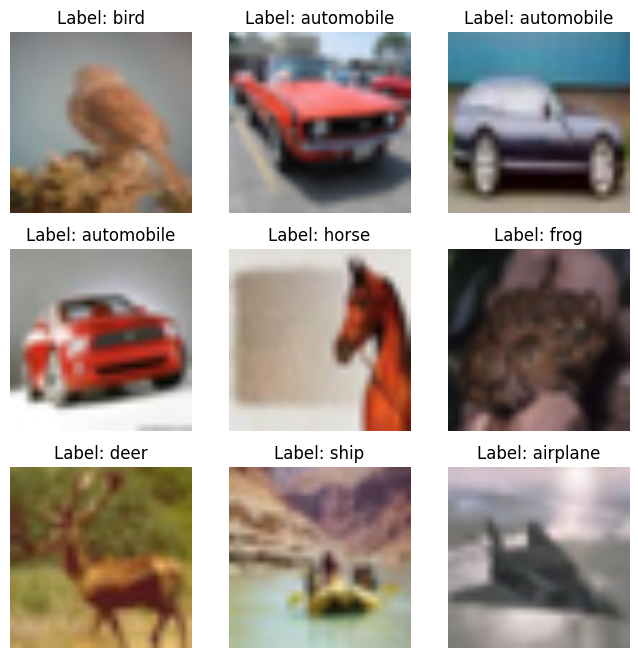

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# 显示一些 CIFAR-10 样本图像
def show_samples(dataset, num_samples=9):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))  # 随机选择索引
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()  # 重新排列维度用于展示
        image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)  # 去归一化

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f'Label: {dataset.classes[label]}')

    plt.show()

# 显示 CIFAR-10 测试集中的随机样本
show_samples(testset)


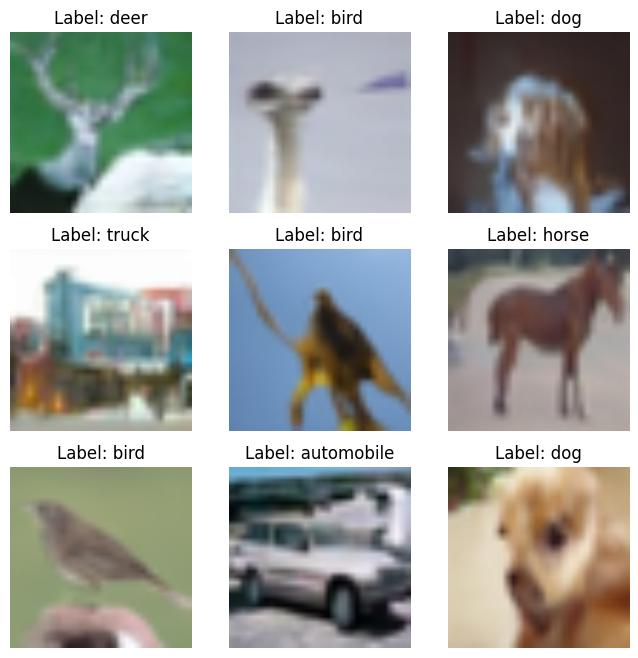

In [24]:
show_samples(trainset_syn)

In [25]:
import torch
import torch.nn as nn
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# 定义提取 ResNet 特征的函数
def extract_features(model, dataloader, device):
    model.eval()
    features_list = []
    labels_list = []

    # 去掉 ResNet 的最后一层（分类层），只提取特征
    feature_extractor = nn.Sequential(*list(model.children())[:-1])

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Extracting Features"):
            inputs = inputs.to(device)
            features = feature_extractor(inputs).squeeze()  # 提取特征
            features_list.append(features.cpu().numpy())     # 存储特征
            labels_list.append(labels.cpu().numpy())         # 存储标签

    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    return features_array, labels_array

# 运行 UMAP 并可视化
def plot_umap_with_labels(features, labels, class_names, n_neighbors=15, min_dist=0.1, n_components=2):
    # 归一化特征
    features = StandardScaler().fit_transform(features)

    # 运行 UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
    embedding = reducer.fit_transform(features)

    # 创建可视化
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=10)
    plt.colorbar(scatter, boundaries=np.arange(len(class_names) + 1) - 0.5).set_ticks(np.arange(len(class_names)))
    plt.clim(-0.5, len(class_names) - 0.5)
    plt.title("UMAP projection with labels")

    # 计算每个类别的中心并显示类别名称
    for class_idx in np.unique(labels):
        # 获取该类别的点
        class_points = embedding[labels == class_idx]
        # 计算中心位置
        center = np.mean(class_points, axis=0)
        # 在中心位置显示类别标签
        plt.text(center[0], center[1], class_names[class_idx], fontsize=9, ha='center', va='center')

    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()



Extracting Features: 100%|██████████| 157/157 [00:08<00:00, 19.23it/s]
/root/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


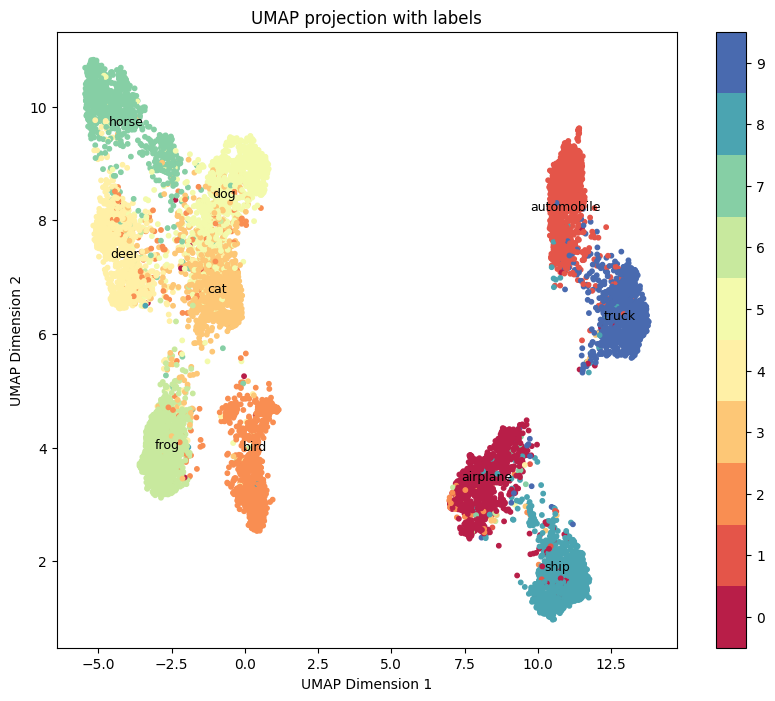

In [26]:

# 提取特征并运行 UMAP
features, labels = extract_features(model, testloader, device)

# 定义类别名称
class_names = testset.classes

# 运行 UMAP 并显示类别标签
plot_umap_with_labels(features, labels, class_names)

# RealData

In [3]:
# 加载数据集
trainset_real = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# 拆分数据集为训练集和验证集
train_size = int(0.8 * len(trainset_real))
val_size = len(trainset_real) - train_size
trainset_real, valset_real = torch.utils.data.random_split(trainset_real, [train_size, val_size])


Files already downloaded and verified


In [4]:

# 创建 DataLoader
num_workers=4
trainloader_real = DataLoader(trainset_real, batch_size=64, shuffle=True,num_workers=num_workers)
valloader_real = DataLoader(valset_real, batch_size=64, shuffle=False,num_workers=num_workers)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=num_workers)

# 初始化模型 预训练模型
model_real = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# 修改输出层
model_real.fc = nn.Linear(model_real.fc.in_features, 10)

model_real = model_real.to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer_real = optim.SGD(model_real.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# 定义 OneCycleLR 学习率调度器

scheduler_real = torch.optim.lr_scheduler.OneCycleLR(optimizer_real, max_lr=0.001, steps_per_epoch=len(trainloader_real), epochs=num_epochs)

# 初始化 TensorBoard
dataset_name = 'CIFAR10'
log_dir = f'/root/tf-logs/{dataset_name}'
writer = SummaryWriter(log_dir=log_dir)

def train_model(model, criterion, optimizer, scheduler, trainloader, valloader, device, num_epochs=10):
    global best_val_loss, patience_counter
    model.train()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        batch_iterator = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        for inputs, labels in batch_iterator:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            batch_iterator.set_postfix(loss=loss.item())
        epoch_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Learning_Rate', scheduler.get_last_lr()[0], epoch)
        print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f} Accuracy: {train_accuracy:.2f}%")

        # 验证模型
        val_loss, val_accuracy = evaluate_model(model, criterion, valloader, device, epoch)
        val_losses.append(val_loss)

    return train_losses, val_losses

# 评估函数
def evaluate_model(model, criterion, dataloader, device, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=">>> Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    writer.add_scalar('Loss/val' if dataloader == valloader_real else 'Loss/test', avg_loss, epoch)
    writer.add_scalar('Accuracy/val' if dataloader == valloader_real else 'Accuracy/test', accuracy, epoch)
    print(f"    Accuracy: {accuracy:.2f}% Avg_Loss: {avg_loss:.4f}")
    return avg_loss, accuracy

# 训练和评估模型
train_model(model_real, criterion, optimizer_real, scheduler_real, trainloader_real, valloader_real, device, num_epochs)
# 关闭 TensorBoard
writer.close()

evaluate_model(model_real, criterion, testloader, device, num_epochs)

Epoch 1/10: 100%|██████████| 625/625 [00:29<00:00, 21.06batch/s, loss=0.539]


Epoch 1 Loss: 1.3262 Accuracy: 59.70%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 32.43batch/s]


    Accuracy: 83.18% Avg_Loss: 0.5731


Epoch 2/10: 100%|██████████| 625/625 [00:30<00:00, 20.28batch/s, loss=0.671] 


Epoch 2 Loss: 0.3317 Accuracy: 88.58%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 34.96batch/s]


    Accuracy: 90.64% Avg_Loss: 0.2753


Epoch 3/10: 100%|██████████| 625/625 [00:28<00:00, 22.03batch/s, loss=0.214] 


Epoch 3 Loss: 0.2022 Accuracy: 92.94%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 36.05batch/s]


    Accuracy: 92.81% Avg_Loss: 0.2100


Epoch 4/10: 100%|██████████| 625/625 [00:28<00:00, 22.10batch/s, loss=0.166] 


Epoch 4 Loss: 0.1363 Accuracy: 95.32%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 35.75batch/s]


    Accuracy: 92.28% Avg_Loss: 0.2313


Epoch 5/10: 100%|██████████| 625/625 [00:29<00:00, 21.24batch/s, loss=0.101]  


Epoch 5 Loss: 0.0909 Accuracy: 96.99%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 34.24batch/s]


    Accuracy: 93.28% Avg_Loss: 0.1999


Epoch 6/10: 100%|██████████| 625/625 [00:29<00:00, 21.47batch/s, loss=0.239]  


Epoch 6 Loss: 0.0571 Accuracy: 98.06%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 34.86batch/s]


    Accuracy: 93.82% Avg_Loss: 0.1974


Epoch 7/10: 100%|██████████| 625/625 [00:28<00:00, 21.62batch/s, loss=0.0238] 


Epoch 7 Loss: 0.0285 Accuracy: 99.08%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 35.14batch/s]


    Accuracy: 93.89% Avg_Loss: 0.2096


Epoch 8/10: 100%|██████████| 625/625 [00:28<00:00, 21.76batch/s, loss=0.00819] 


Epoch 8 Loss: 0.0136 Accuracy: 99.67%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 35.02batch/s]


    Accuracy: 94.53% Avg_Loss: 0.2112


Epoch 9/10: 100%|██████████| 625/625 [00:28<00:00, 21.81batch/s, loss=0.00169] 


Epoch 9 Loss: 0.0046 Accuracy: 99.96%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 35.02batch/s]


    Accuracy: 94.70% Avg_Loss: 0.2170


Epoch 10/10: 100%|██████████| 625/625 [00:30<00:00, 20.49batch/s, loss=0.00285] 


Epoch 10 Loss: 0.0029 Accuracy: 99.99%


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 34.78batch/s]


    Accuracy: 94.69% Avg_Loss: 0.2192


>>> Evaluating: 100%|██████████| 157/157 [00:04<00:00, 34.77batch/s]

    Accuracy: 94.68% Avg_Loss: 0.2092


(0.20915834264159439, 94.68)

Evaluating: 100%|██████████| 157/157 [00:05<00:00, 28.28it/s]


Accuracy: 0.9485
Precision: 0.9486
Recall: 0.9485
F1 Score: 0.9409


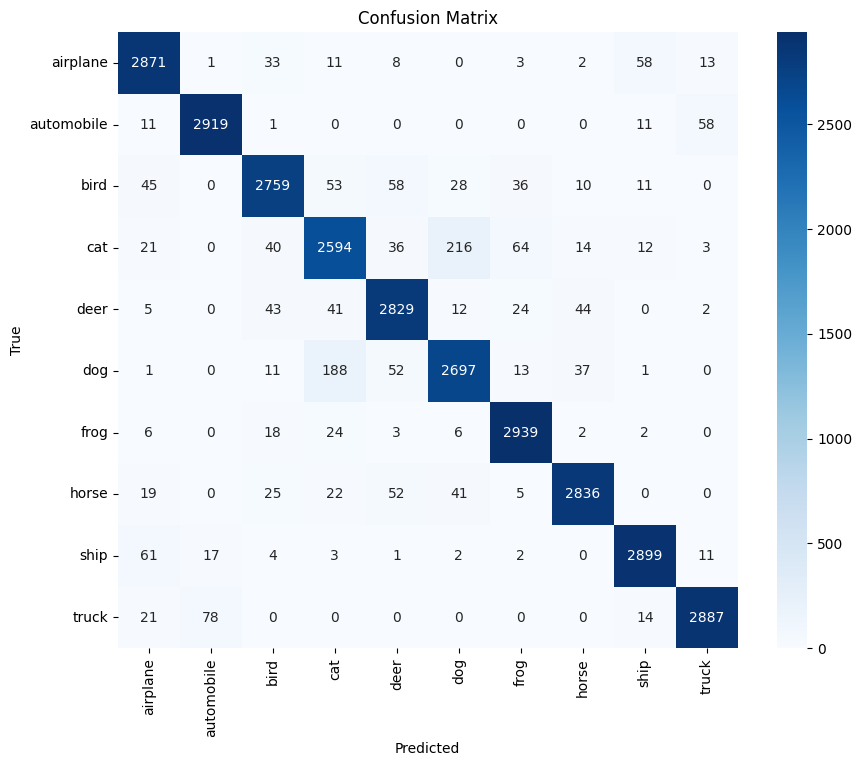

In [28]:
# 在测试集上运行评估
confusion_matrix = evaluate_with_metrics(model_real, testloader, device)
class_names = testset.classes  # CIFAR-10 类别名称
plot_confusion_matrix(confusion_matrix, class_names)

# 重置所有 metrics 以便在其他数据集上使用
accuracy_metric.reset()
precision_metric.reset()
recall_metric.reset()

Extracting Features: 100%|██████████| 157/157 [00:04<00:00, 33.00it/s]
/root/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/root/miniconda3/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


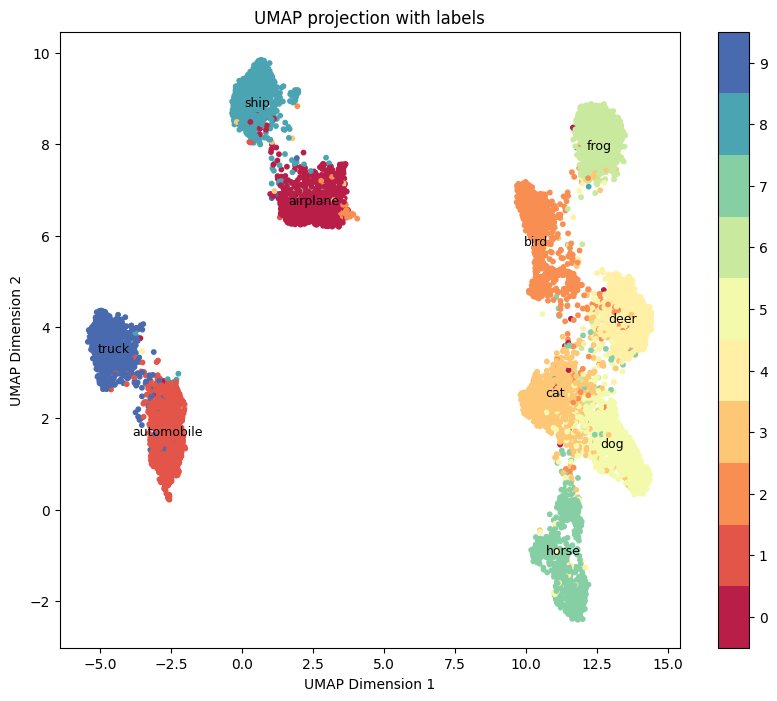

In [18]:
features_real, labels = extract_features(model_real, testloader, device)
class_names = testset.classes
plot_umap_with_labels(features_real, labels, class_names)

In [9]:

def combine_datasets(real_dataset, synthetic_dataset, real_ratio, synthetic_ratio):
    total_real = int(len(real_dataset) * real_ratio / 10)
    total_synthetic = int(len(synthetic_dataset) * synthetic_ratio / 10)
    # Sample from real and synthetic datasets
    real_subset, _ = torch.utils.data.random_split(real_dataset, [total_real, len(real_dataset) - total_real])
    synthetic_subset, _ = torch.utils.data.random_split(synthetic_dataset, [total_synthetic, len(synthetic_dataset) - total_synthetic])
    # Combine the subsets
    combined_dataset = torch.utils.data.ConcatDataset([real_subset, synthetic_subset])
    return combined_dataset

mixed_datasets = {
    '2:8': combine_datasets(trainset_real, trainset_syn, 2, 8),
    '5:5': combine_datasets(trainset_real, trainset_syn, 5, 5),
    '8:2': combine_datasets(trainset_real, trainset_syn, 8, 2)
}
workers=4

train_loader_2_8 = DataLoader(mixed_datasets['2:8'], batch_size=64, shuffle=True,num_workers=workers)
train_loader_5_5 = DataLoader(mixed_datasets['5:5'], batch_size=64, shuffle=True,num_workers=workers)
train_loader_8_2 = DataLoader(mixed_datasets['8:2'], batch_size=64, shuffle=True,num_workers=workers)

In [7]:
from tqdm import trange


def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    model.train()
    train_loss = []
    for epoch in trange(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    
    return train_loss

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')
    return accuracy
# 定义损失函数
criterion = nn.CrossEntropyLoss()
num_epochs=10
# 创建模型的函数
def create_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10有10个分类
    return model.to(device)

# 为每个模型创建优化器和调度器
def create_optimizer_scheduler(model, trainloader):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(trainloader), epochs=num_epochs)
    return optimizer, scheduler

# 创建模型、优化器和调度器
model_2_8 = create_model()
optimizer_2_8, scheduler_2_8 = create_optimizer_scheduler(model_2_8, train_loader_2_8)

model_5_5 = create_model()
optimizer_5_5, scheduler_5_5 = create_optimizer_scheduler(model_5_5, train_loader_5_5)

model_8_2 = create_model()
optimizer_8_2, scheduler_8_2 = create_optimizer_scheduler(model_8_2, train_loader_8_2)

# 修改训练函数以包含调度器
def train_model_with_scheduler(model, train_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    model.to(device)
    model.train()
    train_loss = []
    for epoch in trange(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 更新学习率调度器
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    
    return train_loss


In [8]:

# 训练3个模型
loss_2_8 = train_model_with_scheduler(model_2_8, train_loader_2_8, criterion, optimizer_2_8, scheduler_2_8, device, num_epochs=10)
loss_5_5 = train_model_with_scheduler(model_5_5, train_loader_5_5, criterion, optimizer_5_5, scheduler_5_5, device, num_epochs=10)
loss_8_2 = train_model_with_scheduler(model_8_2, train_loader_8_2, criterion, optimizer_8_2, scheduler_8_2, device, num_epochs=10)

# 在测试集上评估模型
accuracy_2_8 = evaluate_model(model_2_8, testloader, device)
accuracy_5_5 = evaluate_model(model_5_5, testloader, device)
accuracy_8_2 = evaluate_model(model_8_2, testloader, device)


 10%|█         | 1/10 [01:06<09:56, 66.24s/it]

Epoch 1/10, Loss: 1.3509


 20%|██        | 2/10 [02:09<08:34, 64.34s/it]

Epoch 2/10, Loss: 0.4241


 30%|███       | 3/10 [03:14<07:32, 64.71s/it]

Epoch 3/10, Loss: 0.2757


 40%|████      | 4/10 [04:17<06:25, 64.20s/it]

Epoch 4/10, Loss: 0.2039


 50%|█████     | 5/10 [05:21<05:19, 63.88s/it]

Epoch 5/10, Loss: 0.1561


 60%|██████    | 6/10 [06:23<04:13, 63.47s/it]

Epoch 6/10, Loss: 0.1154


 70%|███████   | 7/10 [07:26<03:09, 63.23s/it]

Epoch 7/10, Loss: 0.0837


 80%|████████  | 8/10 [08:28<02:05, 62.89s/it]

Epoch 8/10, Loss: 0.0614


 90%|█████████ | 9/10 [09:35<01:04, 64.13s/it]

Epoch 9/10, Loss: 0.0481


100%|██████████| 10/10 [10:41<00:00, 64.11s/it]


Epoch 10/10, Loss: 0.0426


 10%|█         | 1/10 [01:02<09:19, 62.22s/it]

Epoch 1/10, Loss: 1.3671


 20%|██        | 2/10 [02:00<07:59, 59.92s/it]

Epoch 2/10, Loss: 0.4136


 30%|███       | 3/10 [02:58<06:52, 58.92s/it]

Epoch 3/10, Loss: 0.2648


 40%|████      | 4/10 [04:01<06:03, 60.51s/it]

Epoch 4/10, Loss: 0.1924


 50%|█████     | 5/10 [05:04<05:06, 61.35s/it]

Epoch 5/10, Loss: 0.1400


 60%|██████    | 6/10 [06:04<04:04, 61.10s/it]

Epoch 6/10, Loss: 0.1014


 70%|███████   | 7/10 [07:09<03:06, 62.28s/it]

Epoch 7/10, Loss: 0.0727


 80%|████████  | 8/10 [08:12<02:04, 62.45s/it]

Epoch 8/10, Loss: 0.0533


 90%|█████████ | 9/10 [09:12<01:01, 61.67s/it]

Epoch 9/10, Loss: 0.0426


100%|██████████| 10/10 [10:13<00:00, 61.40s/it]


Epoch 10/10, Loss: 0.0375


 10%|█         | 1/10 [00:56<08:32, 56.94s/it]

Epoch 1/10, Loss: 1.3863


 20%|██        | 2/10 [01:54<07:37, 57.22s/it]

Epoch 2/10, Loss: 0.4101


 30%|███       | 3/10 [02:49<06:34, 56.30s/it]

Epoch 3/10, Loss: 0.2432


 40%|████      | 4/10 [03:46<05:40, 56.74s/it]

Epoch 4/10, Loss: 0.1704


 50%|█████     | 5/10 [04:43<04:43, 56.74s/it]

Epoch 5/10, Loss: 0.1219


 60%|██████    | 6/10 [05:39<03:45, 56.48s/it]

Epoch 6/10, Loss: 0.0868


 70%|███████   | 7/10 [06:35<02:49, 56.37s/it]

Epoch 7/10, Loss: 0.0614


 80%|████████  | 8/10 [07:29<01:51, 55.63s/it]

Epoch 8/10, Loss: 0.0470


 90%|█████████ | 9/10 [08:28<00:56, 56.49s/it]

Epoch 9/10, Loss: 0.0366


100%|██████████| 10/10 [09:23<00:00, 56.34s/it]

Epoch 10/10, Loss: 0.0324


Accuracy: 93.24%
Accuracy: 93.47%
Accuracy: 94.15%


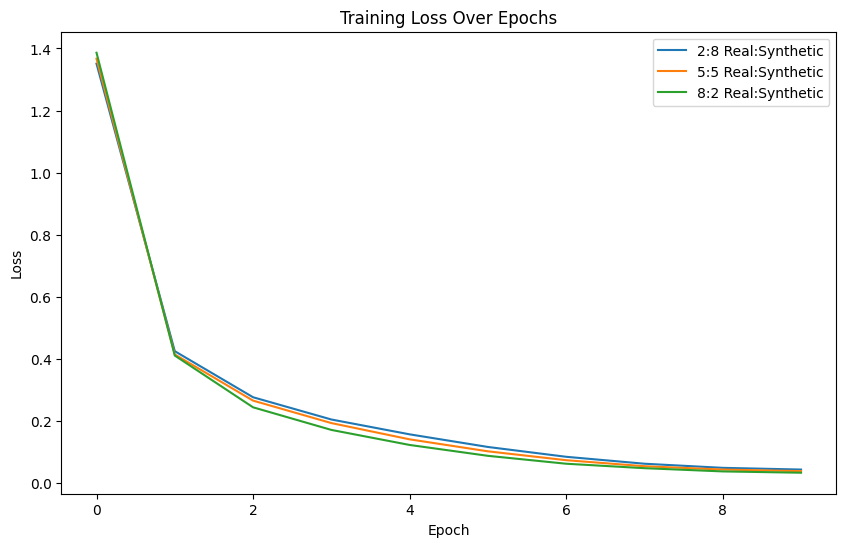

2:8 Real:Synthetic Accuracy: 0.9324
5:5 Real:Synthetic Accuracy: 0.9347
8:2 Real:Synthetic Accuracy: 0.9415


In [19]:

# 可视化训练损失
plt.figure(figsize=(10,6))
plt.plot(loss_2_8, label="2:8 Real:Synthetic")
plt.plot(loss_5_5, label="5:5 Real:Synthetic")
plt.plot(loss_8_2, label="8:2 Real:Synthetic")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 打印每个比例的准确率
print(f"2:8 Real:Synthetic Accuracy: {accuracy_2_8:.4f}")
print(f"5:5 Real:Synthetic Accuracy: {accuracy_5_5:.4f}")
print(f"8:2 Real:Synthetic Accuracy: {accuracy_8_2:.4f}")
